In [ ]:
from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, 
    GlobalAveragePooling2D, Multiply, Add,Layer
)
from tensorflow.keras.utils import to_categorical, Sequence
import tensorflow as tf

accuracy 99


In [ ]:

DATASET_DIR = r"C:\Users\mgree\Downloads\Dataset CAUCAFall\Dataset CAUCAFall\CAUCAFall"
CATEGORIES = {
    'Fall forward': 0, 'Fall backwards': 1, 'Fall left': 2,
    'Fall right': 3, 'Fall sitting': 4, 'Walk': 5,
    'Hop': 6, 'Pick up object': 7, 'Sit down': 8, 'Kneel': 9
}


In [ ]:
def load_file_paths_and_labels(dataset_dir, categories):
    file_paths = []
    labels = []
    for subject in os.listdir(dataset_dir):
        subject_path = os.path.join(dataset_dir, subject)
        if not os.path.isdir(subject_path):
            continue
        
        for action, label in categories.items():
            action_path = os.path.join(subject_path, action)
            if not os.path.isdir(action_path):
                continue
            
            for frame_file in os.listdir(action_path):
                if frame_file.endswith(".png"):
                    file_paths.append(os.path.join(action_path, frame_file))
                    labels.append(label)
    return file_paths, labels

file_paths, labels = load_file_paths_and_labels(DATASET_DIR, CATEGORIES)
train_files, test_files, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=42
)
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size=32, input_size=(112, 112), num_classes=10, shuffle=True):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.input_size = input_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.file_paths) // self.batch_size

    def __getitem__(self, index):
        batch_files = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        
        X, y = self._load_batch(batch_files, batch_labels)
        return X, y

    def _load_batch(self, batch_files, batch_labels):
        X = []
        y = []
        for file_path, label in zip(batch_files, batch_labels):
            frame = cv2.imread(file_path)
            frame = cv2.resize(frame, self.input_size)
            X.append(frame)
            y.append(label)
        X = np.array(X, dtype='float32') / 255.0
        y = to_categorical(y, num_classes=self.num_classes)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.file_paths, self.labels))
            np.random.shuffle(temp)
            self.file_paths, self.labels = zip(*temp)


train_generator = DataGenerator(train_files, train_labels, batch_size=16, num_classes=len(CATEGORIES))
val_generator = DataGenerator(val_files, val_labels, batch_size=16, num_classes=len(CATEGORIES))
test_generator = DataGenerator(test_files, test_labels, batch_size=16, num_classes=len(CATEGORIES), shuffle=False)


In [ ]:
class SpatialAttention(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        attention = self.conv(concat)
        return Multiply()([inputs, attention])

class ChannelAttention(Layer):
    def __init__(self, reduction_ratio=8, **kwargs):
        super().__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.dense1 = Dense(input_shape[-1] // self.reduction_ratio, activation='relu')
        self.dense2 = Dense(input_shape[-1], activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)

        avg_out = self.dense2(self.dense1(avg_pool))
        max_out = self.dense2(self.dense1(max_pool))
        attention = Add()([avg_out, max_out])
        return Multiply()([inputs, attention])

In [ ]:
def build_custom_attention_cnn(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = SpatialAttention()(x)
    x = ChannelAttention()(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = SpatialAttention()(x)
    x = ChannelAttention()(x)

    x = Flatten()(x)  

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


input_shape = (112, 112, 3)
num_classes = len(CATEGORIES)

model = build_custom_attention_cnn(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    verbose=1
)

model.save("custom_attention_model_with_flattening.h5")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 349s 434ms/step - accuracy: 0.2914 - loss: 1.9007 - val_accuracy: 0.7919 - val_loss: 0.6194
Epoch 2/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 366s 457ms/step - accuracy: 0.7220 - loss: 0.7471 - val_accuracy: 0.8847 - val_loss: 0.3160
Epoch 3/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 357s 447ms/step - accuracy: 0.8052 - loss: 0.5014 - val_accuracy: 0.9128 - val_loss: 0.2340
Epoch 4/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 357s 447ms/step - accuracy: 0.8506 - loss: 0.3943 - val_accuracy: 0.9294 - val_loss: 0.1732
Epoch 5/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 396s 495ms/step - accuracy: 0.8737 - loss: 0.3131 - val_accuracy: 0.9503 - val_loss: 0.1388
Epoch 6/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 446s 558ms/step - accuracy: 0.8941 - loss: 0.2649 - val_accuracy: 0.9663 - val_loss: 0.0938
Epoch 7/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 461s 576ms/step - accuracy: 0.9106 - loss: 0.2284 - val_accuracy: 0.9697 - val_loss: 0.0889
Epoch 8/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 658s 823ms/step - accuracy: 0.9199 -

250/250 ━━━━━━━━━━━━━━━━━━━━ 88s 353ms/step - accuracy: 0.9856 - loss: 0.0625
Test Accuracy: 98.35%


In [ ]:

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope

with custom_object_scope({'SpatialAttention': SpatialAttention, 'ChannelAttention': ChannelAttention}):
    model = load_model('custom_attention_model_with_flattening.h5')
import cv2
import numpy as np
from collections import Counter

def predict_from_video(video_path, model, categories, frame_skip=10, input_size=(112, 112)):
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Unable to open video file: {video_path}")

    frame_count = 0
    predictions = []
    category_labels = list(categories.keys())  

    while True:
        ret, frame = cap.read()
        if not ret:
            break  

        if frame_count % frame_skip == 0:
            
            resized_frame = cv2.resize(frame, input_size)
            normalized_frame = np.expand_dims(resized_frame / 255.0, axis=0)  

            preds = model.predict(normalized_frame, verbose=0)
            predicted_class = np.argmax(preds)  

            if 0 <= predicted_class < len(category_labels):
                predicted_action = category_labels[predicted_class]  
                predictions.append(predicted_action)  
            else:
                print(f"Invalid prediction index: {predicted_class}")
                predictions.append("Unknown") 

            cv2.putText(frame, f"Prediction: {predicted_action}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.imshow("Video Prediction", frame)

        frame_count += 1

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


    if predictions:
        most_common_prediction = Counter(predictions).most_common(1)[0][0]
    else:
        most_common_prediction = "No predictions made."

    return most_common_prediction, predictions


video_path = r"C:\Users\mgree\Downloads\Untitled video - Made with Clipchamp.mp4"

most_common_action, frame_predictions = predict_from_video(video_path, model, CATEGORIES, frame_skip=10)


print(f"Most common action in the video: {most_common_action}")
frame_predictions = [str(action) for action in frame_predictions]
print(f"Frame-wise predictions: {', '.join(frame_predictions)}")



Most common action in the video: Walk
Frame-wise predictions: Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk


In [ ]:
def build_alternate_attention_cnn(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = SpatialAttention()(x)  
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = ChannelAttention()(x)

    x = Flatten()(x)  

    x = Dense(256, activation='relu')(x) 
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

input_shape = (112, 112, 3)
num_classes = len(CATEGORIES)
alternate_model = build_alternate_attention_cnn(input_shape, num_classes)
alternate_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

alternate_history = alternate_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    verbose=1
)

alternate_model.save("alternate_attention_model_with_flattening.h5")


c:\Users\mgree\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 391s 485ms/step - accuracy: 0.3174 - loss: 1.8778 - val_accuracy: 0.8100 - val_loss: 0.5673
Epoch 2/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 318s 398ms/step - accuracy: 0.7698 - loss: 0.6304 - val_accuracy: 0.9141 - val_loss: 0.2424
Epoch 3/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 319s 398ms/step - accuracy: 0.8680 - loss: 0.3544 - val_accuracy: 0.9431 - val_loss: 0.1714
Epoch 4/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 419s 523ms/step - accuracy: 0.9097 - loss: 0.2417 - val_accuracy: 0.9581 - val_loss: 0.1151
Epoch 5/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 348s 434ms/step - accuracy: 0.9344 - loss: 0.1781 - val_accuracy: 0.9737 - val_loss: 0.0708
Epoch 6/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 446s 558ms/step - accuracy: 0.9389 - loss: 0.1552 - val_accuracy: 0.9787 - val_loss: 0.0607
Epoch 7/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 329s 411ms/step - accuracy: 0.9539 - loss: 0.1227 - val_accuracy: 0.9822 - val_loss: 0.0551
Epoch 8/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 318s 398ms/step - accuracy: 0.9582 -

In [19]:
with custom_object_scope({'SpatialAttention': SpatialAttention, 'ChannelAttention': ChannelAttention}):
    model1 = load_model('custom_attention_model_with_flattening.h5')
    model2 = load_model('alternate_attention_model_with_flattening.h5')

models = [model1, model2]


In [ ]:
def ensemble_predict(models, frame, input_size):
    resized_frame = cv2.resize(frame, input_size)
    normalized_frame = np.expand_dims(resized_frame / 255.0, axis=0)

    predictions = np.zeros((1, len(CATEGORIES)))
    for model in models:
        preds = model.predict(normalized_frame, verbose=0)
        predictions += preds
    predictions /= len(models)  
    return np.argmax(predictions)


In [ ]:
def predict_from_video_with_ensemble(video_path, models, categories, frame_skip=10, input_size=(112, 112)):
   
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Unable to open video file: {video_path}")

    frame_count = 0
    predictions = []
    category_labels = list(categories.keys())  

    while True:
        ret, frame = cap.read()
        if not ret:
            break  

        if frame_count % frame_skip == 0:
        
            predicted_class = ensemble_predict(models, frame, input_size)

            if 0 <= predicted_class < len(category_labels):
                predicted_action = category_labels[predicted_class]  
                predictions.append(predicted_action)  
            else:
                predictions.append("Unknown") 

            cv2.putText(frame, f"Prediction: {predicted_action}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.imshow("Video Prediction", frame)

        frame_count += 1

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    if predictions:
        most_common_prediction = Counter(predictions).most_common(1)[0][0]
    else:
        most_common_prediction = "No predictions made."

    return most_common_prediction, predictions

video_path = r"C:\Users\mgree\Downloads\Untitled video - Made with Clipchamp.mp4" 

most_common_action, frame_predictions = predict_from_video_with_ensemble(video_path, models, CATEGORIES, frame_skip=10)
print(f"Most common action in the video: {most_common_action}")
print(f"Frame-wise predictions: {', '.join(frame_predictions)}")

Most common action in the video: Walk
Frame-wise predictions: Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk, Walk


In [28]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope

# Load the models with the custom layers defined
with custom_object_scope({'SpatialAttention': SpatialAttention, 'ChannelAttention': ChannelAttention}):
    model1 = load_model('custom_attention_model_with_flattening.h5')
    model2 = load_model('alternate_attention_model_with_flattening.h5')

# Evaluate accuracy for both models
print("Evaluating Custom Attention Model:")
test_loss1, test_accuracy1 = model1.evaluate(test_generator, verbose=1)
print(f"Custom Attention Model Accuracy: {test_accuracy1 * 100:.2f}%")

print("\nEvaluating Alternate Attention Model:")
test_loss2, test_accuracy2 = model2.evaluate(test_generator, verbose=1)
print(f"Alternate Attention Model Accuracy: {test_accuracy2 * 100:.2f}%")


Evaluating Custom Attention Model:
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 151ms/step - accuracy: 0.9856 - loss: 0.0625
Custom Attention Model Accuracy: 98.35%

Evaluating Alternate Attention Model:
250/250 ━━━━━━━━━━━━━━━━━━━━ 73s 291ms/step - accuracy: 0.9887 - loss: 0.0568
Alternate Attention Model Accuracy: 98.80%


In [33]:
y_true = []
y_pred1 = []
y_pred2 = []

# Iterate over batches
for i in range(len(test_generator)):
    X, y = test_generator[i]  # Access the batch
    y_true.extend(np.argmax(y, axis=1))  # True labels
    y_pred1.extend(np.argmax(model1.predict(X, verbose=0), axis=1))  # Model 1 predictions
    y_pred2.extend(np.argmax(model2.predict(X, verbose=0), axis=1))  # Model 2 predictions

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred1 = np.array(y_pred1)
y_pred2 = np.array(y_pred2)

# Generate classification metrics
from sklearn.metrics import classification_report, confusion_matrix

# Custom Attention Model Metrics
print("Classification Report for Custom Attention Model:")
print(classification_report(y_true, y_pred1, target_names=CATEGORIES.keys()))

print("Confusion Matrix for Custom Attention Model:")
print(confusion_matrix(y_true, y_pred1))

# Alternate Attention Model Metrics
print("\nClassification Report for Alternate Attention Model:")
print(classification_report(y_true, y_pred2, target_names=CATEGORIES.keys()))

print("Confusion Matrix for Alternate Attention Model:")
print(confusion_matrix(y_true, y_pred2))


Classification Report for Custom Attention Model:
                precision    recall  f1-score   support

  Fall forward       1.00      0.97      0.99       341
Fall backwards       0.99      0.99      0.99       415
     Fall left       0.99      0.99      0.99       369
    Fall right       0.99      1.00      1.00       375
  Fall sitting       1.00      1.00      1.00       434
          Walk       0.92      0.99      0.95       454
           Hop       0.98      0.89      0.93       355
Pick up object       1.00      1.00      1.00       412
      Sit down       1.00      0.99      1.00       419
         Kneel       0.98      0.99      0.98       426

      accuracy                           0.98      4000
     macro avg       0.98      0.98      0.98      4000
  weighted avg       0.98      0.98      0.98      4000

Confusion Matrix for Custom Attention Model:
[[332   4   1   0   0   1   0   0   0   3]
 [  0 412   2   1   0   0   0   0   0   0]
 [  0   1 367   1   0   0   0   

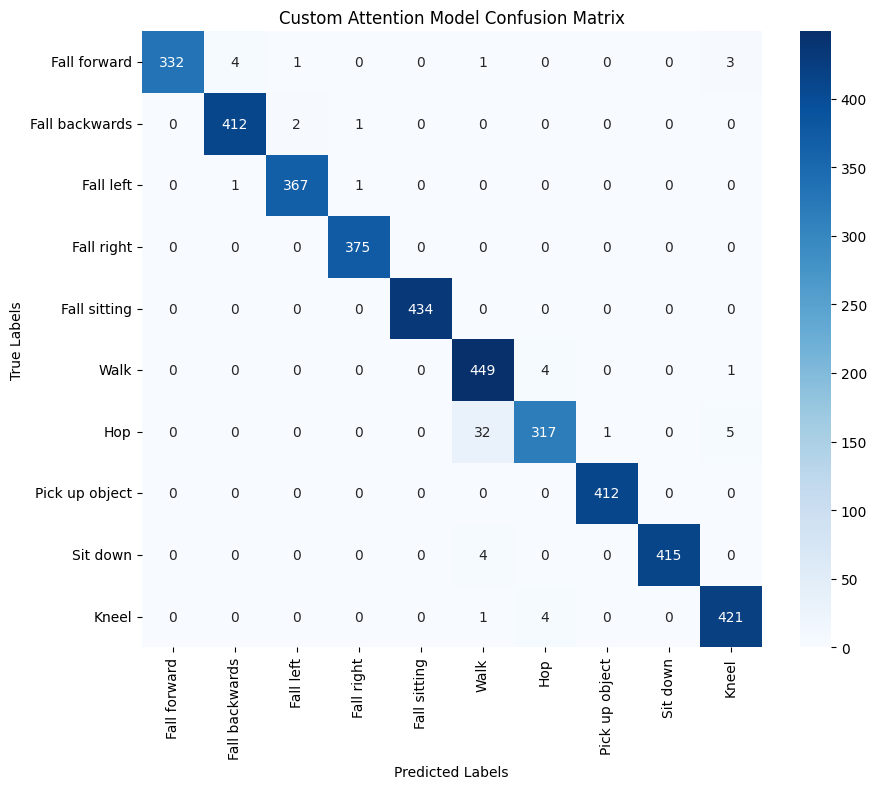

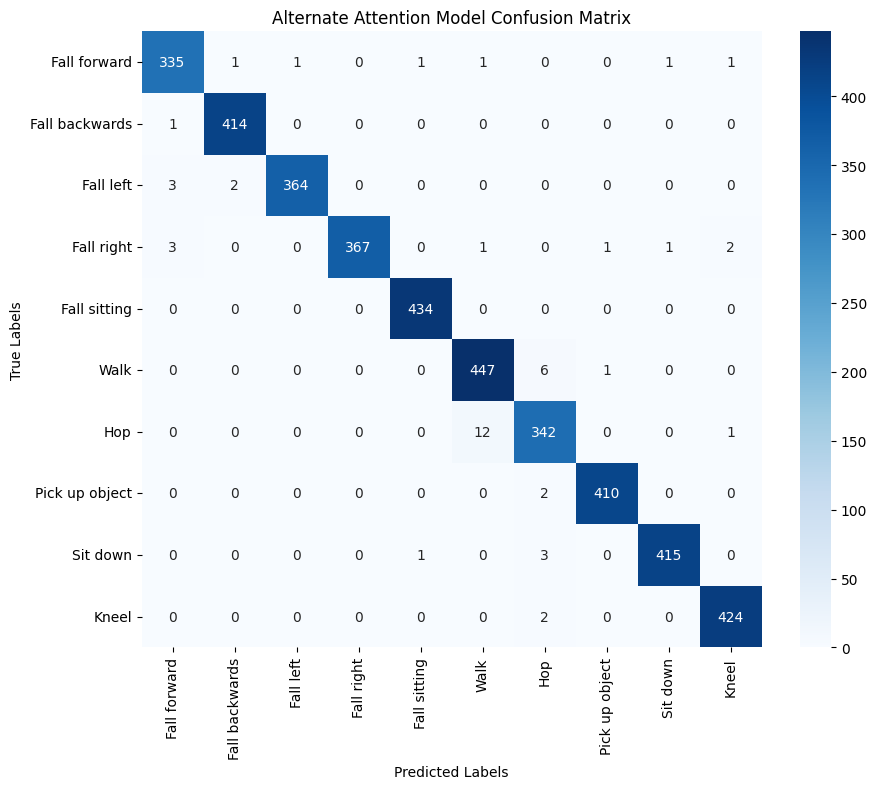

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    """
    Plots a confusion matrix using seaborn heatmap.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# Calculate confusion matrices for both models
cm1 = confusion_matrix(y_true, y_pred1)
cm2 = confusion_matrix(y_true, y_pred2)

# Plot confusion matrix for Custom Attention Model
plot_confusion_matrix(cm1, list(CATEGORIES.keys()), title="Custom Attention Model Confusion Matrix")

# Plot confusion matrix for Alternate Attention Model
plot_confusion_matrix(cm2, list(CATEGORIES.keys()), title="Alternate Attention Model Confusion Matrix")
